In [20]:
import os
import numpy as np

In [21]:
try:
    base_dir = './dataset/'
    train_dir = os.path.join(base_dir,'train')
    preview_dir = os.path.join(base_dir,'preview')
    validation_dir = os.path.join(base_dir,'validation')
    test_dir = os.path.join(base_dir,'test')
    
    train_fbanana_dir = os.path.join(train_dir,'freshbanana')
    train_foranges_dir = os.path.join(train_dir,'freshoranges')
    train_roranges_dir = os.path.join(train_dir,'rottenoranges')
    train_rbanana_dir = os.path.join(train_dir,'rottenbanana')
    
    val_fbanana_dir = os.path.join(validation_dir,'freshbanana')
    val_rbanana_dir = os.path.join(validation_dir,'rottenbanana')
    val_foranges_dir = os.path.join(validation_dir,'freshoranges')
    val_roranges_dir = os.path.join(validation_dir,'rottenoranges')
    
    test_fresh_bananas_dir = os.path.join(test_dir, 'freshbanana')
    test_fresh_oranges_dir = os.path.join(test_dir, 'freshoranges')
    test_rotten_bananas_dir = os.path.join(test_dir, 'rottenbanana')
    test_rotten_oranges_dir = os.path.join(test_dir, 'rottenoranges')
    
    print('total fresh training banana images: ',len(os.listdir(train_fbanana_dir)))
    print('total fresh training oranges images: ',len(os.listdir(train_foranges_dir)))
    print('total rotten training oranges images: ',len(os.listdir(train_roranges_dir)))
    print('total rotten banana oranges images: ',len(os.listdir(train_rbanana_dir)))
    print('total val fresh banana images: ',len(os.listdir(val_fbanana_dir)))
    print('total val fresh oranges images: ',len(os.listdir(val_foranges_dir)))
    print('total val rotten oranges images: ',len(os.listdir(val_roranges_dir)))
    print('total val rotten banana images: ',len(os.listdir(val_rbanana_dir)))
    

except OSError:
    pass

total fresh training banana images:  1581
total fresh training oranges images:  1466
total rotten training oranges images:  1595
total rotten banana oranges images:  2224
total val fresh banana images:  381
total val fresh oranges images:  388
total val rotten oranges images:  241
total val rotten banana images:  530


In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [83]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2, #0.2, 0.5
    height_shift_range=0.2, #0.2, 0.5
    shear_range=0.2,
    zoom_range=[0.5, 1.0], # 0.2, 0.5, [0.5,1.0]
    rotation_range=90, #20, 40, 60, 90
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect' #nearest, reflect, wrap
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [84]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

<ipython-input-85-608946cf5ecf>:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot((len(preview_img)/4)+1, 4, n+1)


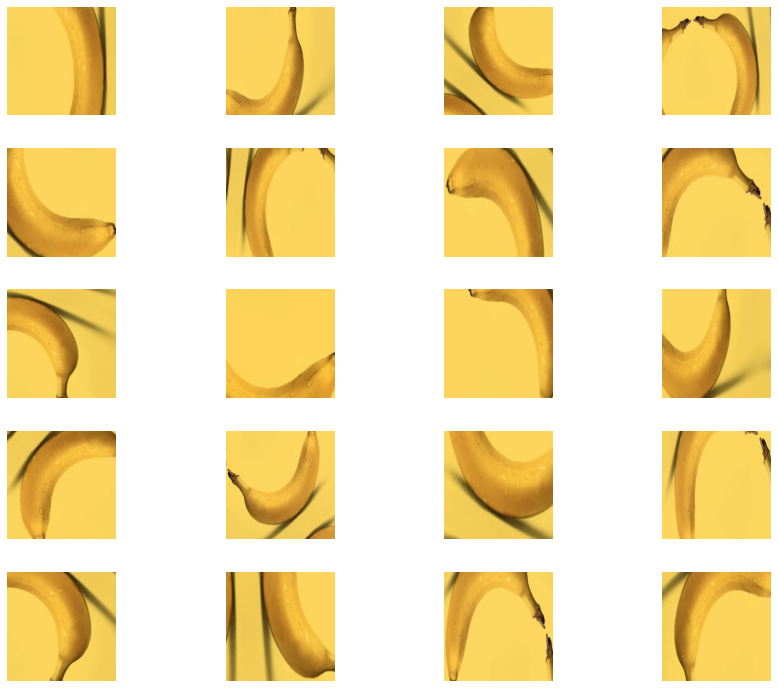

In [85]:
path_aug = os.path.join(train_fbanana_dir, os.listdir(train_fbanana_dir)[-1])
img_augmentation = image.load_img(path_aug)
x_aug = image.img_to_array(img_augmentation)
x_aug = x_aug.reshape((1,) + x_aug.shape)

i = 0
for batch in train_datagen.flow(x_aug, batch_size=1, save_to_dir=preview_dir, save_prefix='fruit', save_format='jpeg'):
    i += 1
    if i >= 20:
        break

preview_img = os.listdir(preview_dir)

plt.figure(figsize=(15, 15))
for n in range(len(preview_img)):
  plt.subplot((len(preview_img)/4)+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image.load_img(os.path.join(preview_dir, preview_img[n]),
                            color_mode="rgb",
                            target_size=(224, 224),
                            interpolation="nearest"))
  plt.axis('off')
plt.show()

for fn in preview_img:
  os.system(f'rm {os.path.join(preview_dir, fn)}')

<h3>Image Generator<h3>

In [86]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    # shuffle = False,
                                                    target_size=(224,224), #?
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         batch_size=32,
                                                         color_mode="rgb",
                                                         # shuffle = False,
                                                         target_size=(224,224), #?
                                                         class_mode='categorical')

Found 6866 images belonging to 4 classes.
Found 1540 images belonging to 4 classes.


In [87]:
import tensorflow as tf

#### Model

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard 
from keras.layers.normalization import BatchNormalization

In [101]:
model = Sequential()

model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

In [102]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 10, 10, 256)       1024      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 8, 8, 256)       

In [103]:
train_len = 0
for foldername in os.listdir('./dataset/train'):
    train_len = train_len + len(os.listdir(os.path.join('./dataset/train',foldername)))
    
val_len = 0
for foldername in os.listdir('./dataset/validation'):
    val_len = val_len + len(os.listdir(os.path.join('./dataset/validation',foldername)))

print(train_len)
print(val_len)

6866
1540


In [104]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [105]:
from keras.callbacks import TensorBoard
import numpy as np
np.random.seed(42)

In [106]:
tensorbrd = TensorBoard('logs/alexnet')

In [107]:
history = model.fit(train_generator, validation_data=validation_generator, batch_size=32, epochs=3, verbose=1, callbacks=[tensorbrd])

Epoch 1/3
  1/215 [..............................] - ETA: 0s - loss: 1.7163 - accuracy: 0.2188WARNING:tensorflow:From C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
215/215 [==============================] - 249s 1s/step - loss: 1.3790 - accuracy: 0.6962 - val_loss: 2.0437 - val_accuracy: 0.4864
Epoch 2/3
215/215 [==============================] - 248s 1s/step - loss: 0.8440 - accuracy: 0.7601 - val_loss: 1.0163 - val_accuracy: 0.7909
Epoch 3/3
215/215 [==============================] - 253s 1s/step - loss: 0.7400 - accuracy: 0.7823 - val_loss: 1.0551 - val_accuracy: 0.6571


<Figure size 432x288 with 0 Axes>

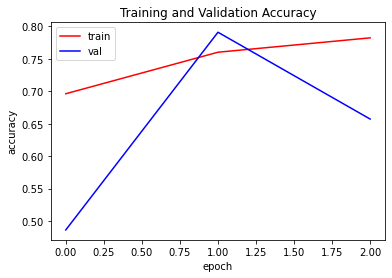

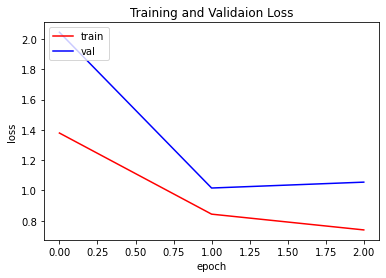

<Figure size 432x288 with 0 Axes>

In [109]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.figure()

In [111]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(validation_dir,
                                                  batch_size=1,
                                                  target_size=(224, 224),
                                                  shuffle = False,
                                                  class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)
print('loss : ',loss)

Found 1540 images belonging to 4 classes.
1540/1540 [==============================] - 25s 16ms/step - loss: 1.0087 - accuracy: 0.6662
accuracy test:  0.6662337779998779
loss :  1.0087131261825562
